# Preprocessing and Modeling
Diagnosing Pneumonia with X-Ray image data.

## Table of Contents
* [Data Loading and EDA](#chapter1)
    
* [Modeling](#chapter2)
    

The first half of this notebook is the same as the Data Wrangling and EDA notebook. Because of the way the data is organized/transformed, it seemed more natural to proceed to the preprocessing/modeling in the same notebook (instead of loading into a separate one), so I'll make a link to where the Modeling begins. 

    https://linuxhint.com/add-table-contents-jupyter-notebook/

## Data Loading and EDA <a class="anchor" id="chapter1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import shutil

In [2]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from torch.utils.data import ConcatDataset, Subset
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data import random_split
import math

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
from pathlib import Path
from collections import Counter

In [6]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data Overview

In [7]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [8]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [9]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [10]:
#folder of 16 extra validation photos
val_16 = []
vN = val_dir / 'NORMAL'
vP = val_dir / 'PNEUMONIA'

for x in normal:
    val_16.append((x,0))
for y in pneumo:
    val_16.append((y,1))

In [11]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [12]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [13]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [14]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

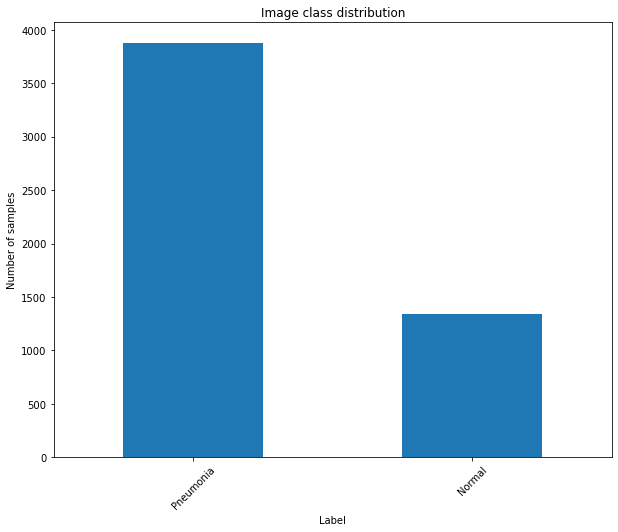

In [15]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

# Images in our training set

Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

In [16]:
def df_img_row(df, target, n = 5,figsize = (20,20),title = None):
    pics= (df[df['label']==target]['image'].iloc[:n]).tolist()
    plt.figure(figsize = figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = plt.imread(pics[i])
        plt.imshow(img,cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()

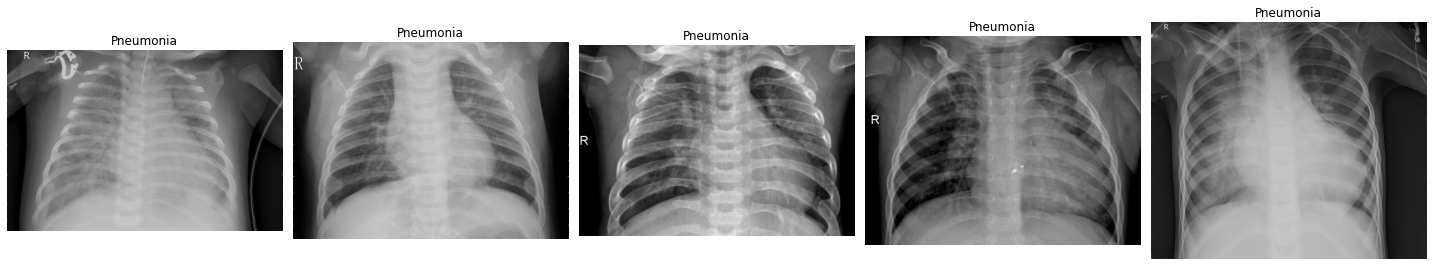

In [17]:
df_img_row(trainDF,1, title = "Pneumonia")

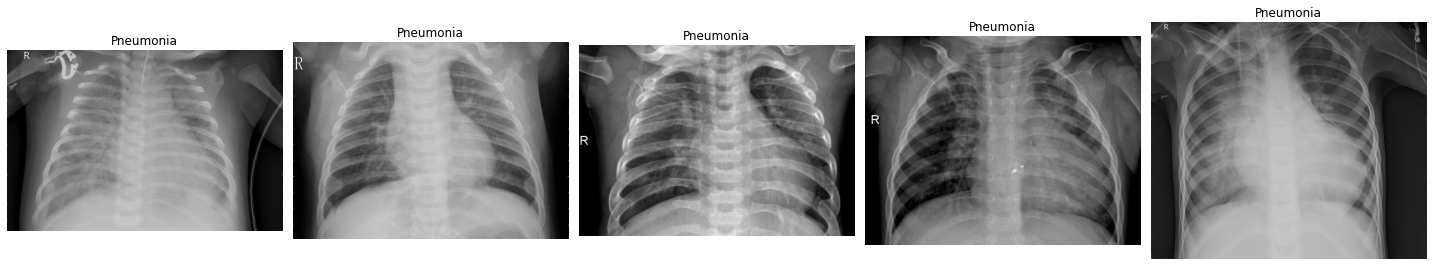

In [18]:
pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')
    
plt.tight_layout()

In [19]:
pneumo_pics

[WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')]

And here are 5 pictures of X-Ray's that were diagnosed as normal.

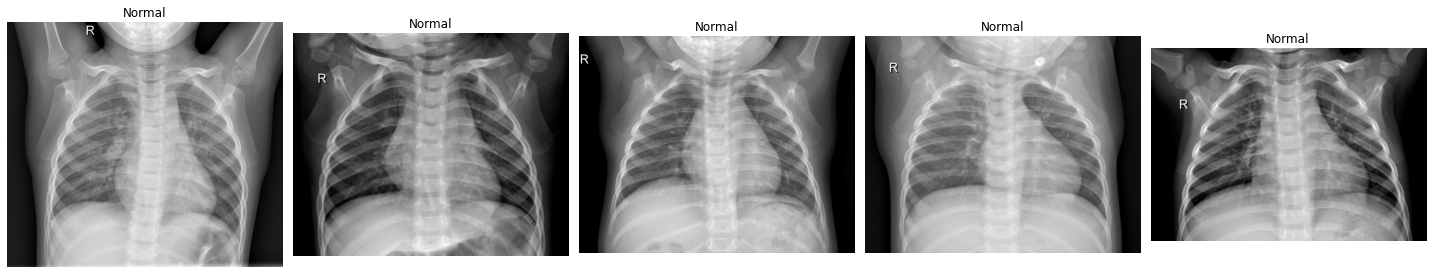

In [20]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Normal")
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

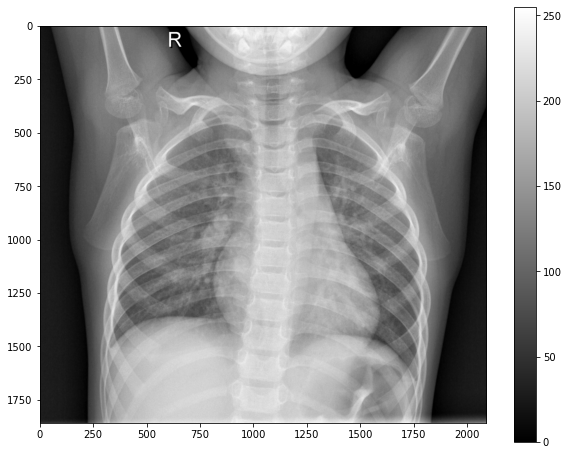

In [21]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [22]:
img.shape

(1858, 2090)

In [23]:
#Lets see what some of the other image dimensions are. 

for i in range(5):
    img = plt.imread(normal_pics[i])
    print(img.shape)

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)
(1125, 1600)


In [24]:
for i in range(5):
    img = plt.imread(pneumo_pics[i])
    print(img.shape)

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)
(1280, 1488)


We will want to include resizing in our preprocessing to account for the differences in image size seen here. 

# Set aside validation data

85/15 split (15 for model tuning). We will use the actual test folder data for final model evaluation. 

In [25]:
from sklearn.model_selection import train_test_split

In [32]:
training, valid = train_test_split(train, test_size = 0.2,shuffle = False)

In [28]:
total = len(train)
train_size = int(0.85*total)
val_size = total - train_size
print(total, train_size, val_size)

5216 4433 783


In [29]:
### maybe
train_data, test_data = torch.utils.data.random_split(train, [train_size, val_size])

another 85/15 split, this time with the 15% set being for training validation. we will add in the 16 validation folder images to this smaller set. 

In [26]:
tot2 = len(train_data)
tr_size = int(0.85*tot2)
v_size = tot2-tr_size
print(tot2,tr_size,v_size)

4433 3768 665


In [30]:
train_data, val_data = torch.utils.data.random_split(train_data, [tr_size, v_size])

In [35]:
train_data, val_data = list(train_data),list(val_data)

In [36]:
type(train_data)
#type(train)

list

In [34]:
trainDF = pd.DataFrame(training, columns = ['image','label'],index = None)

In [35]:
trainDF.label.value_counts()

1    2831
0    1341
Name: label, dtype: int64

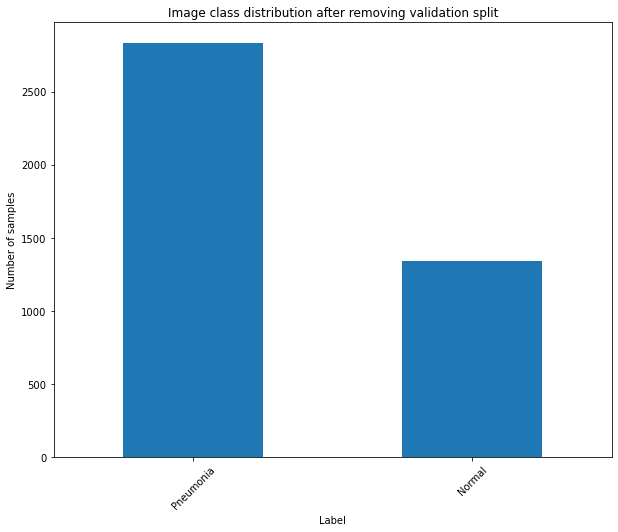

In [36]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution after removing validation split')
plt.show()

so, we need about 2000 more normal images

In [33]:
training[0][0]

WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

In [52]:
train_data[0][1]

1

In [40]:
copy_dir = Path('../data/augNormal')
new_dir = copy_dir / 'train_subset'
n_path = new_dir / 'NORMAL'
p_path = new_dir / 'PNEUMONIA'

In [41]:
new_testdir = copy_dir / 'test_subset'
new_valdir = copy_dir / 'val_subset'

In [56]:
val_data[0][1]

1

In [57]:
val_data[0][0]

WindowsPath('../data/chest_xray/train/PNEUMONIA/person1159_virus_1944.jpeg')

In [58]:
len(val_data)

665

In [43]:
npN = new_valdir / 'NORMAL'
npP = new_valdir / 'PNEUMONIA'

In [44]:
TPN = new_testdir / 'NORMAL'
TPP = new_testdir / 'PNEUMONIA'

In [64]:
len(test_data)

783

In [66]:
test_data[0][1]

0

In [68]:
for x in test_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, TPN)
    elif lab == 1:
        shutil.copy(jpgfile, TPP)

In [63]:
for x in val_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, npN)
    elif lab == 1:
        shutil.copy(jpgfile, npP)

In [48]:
import glob
import shutil
import os

In [54]:
for x in train_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, n_path)
    elif lab == 1:
        shutil.copy(jpgfile, p_path)

    for x in train_data:
        src, lab = x[0], x[1]
        jpgfile = src
        shutil.copy(jpgfile, new_dir)


    src_dir = "your/source/dir"
    dst_dir = "your/destination/dir"
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir)

In [22]:
#train_raw = datasets.ImageFolder(train_dir)

In [43]:
val_16 = []
vN = val_dir / 'NORMAL'
vP = val_dir / 'PNEUMONIA'

for x in normal:
    val_16.append((x,0))
for y in pneumo:
    val_16.append((y,1))

In [23]:
#val_16 = datasets.ImageFolder(val_dir)

In [24]:
total = len(train_raw)

In [25]:
total

5216

In [ ]:
train_raw = datasets.ImageFolder(new_dir)


# Image Augmentations

We will use the torchvision transforms library in this section. There are 2 main objectives here. The first is to balance our classes, that is to use augmentations to increase the number of "normal" class images in our training data to match the number of "pneumonia" class images. The second is to resize the images and normalize their channel values to have consistent data to train our network on. For now we will use the mean and std from imagenet for normalization ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), but may play with this in the tuning stage of the project. 

## Class Imbalance

There are several ways we could go about dealing with the class imbalance. We could generate more "Normal" images, and add them in to our current normal images before training. 
Alternatively, we could write a function to generate images as we go on a batch by batch basis, or change the weighting in the loss function used.

For now we will try generating more "normal" images using augmentations. In our training set, there are 3875 "Pneumonia" images and 1341 "Normal" images. his means we need more than twice the number of images currently availible. So, we will use 2 sets of transform compositions to augment the original training data. For the sake of avoiding duplicates/unrepresentative data, I didn't want to perform the same transforms twice in a row. Because we are dealing with medical images, some augmentation techniques wouldn't make much sense (i.e. horizontal reflections), as such an image would never be possible from scanning a human body. I also didn't want to blur, crop or rotate the images too dramatically, as any future data probably wouldn't be well represented by this. 


In [37]:
class_names = ['NORMAL', 'PNEUMONIA']

### First set of transforms

    #https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
    class DatasetFromSubset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

In [49]:
copy_dir = Path('../data/augNormal')
new_dir = copy_dir / 'train_subset'
n_path = new_dir / 'NORMAL'
p_path = new_dir / 'PNEUMONIA'

In [51]:
extra1 = ImageFolder(new_dir, transform = normal_transforms)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [38]:
normal_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.5, 1.0)),
        transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [47]:
train_data[0]

(WindowsPath('../data/chest_xray/train/PNEUMONIA/person1717_bacteria_4534.jpeg'),
 1)

In [45]:
extra_normal1 = ImageFolder(new_dir, transform = normal_transforms)

In [80]:
extra_normal1[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [81]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

In [82]:
len(extra_normal1)

3768

Lets take a look at a batch of these images to see if these transforms create what we want to add. 

In [55]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [57]:
normDL1 = DataLoader(extra1, batch_size = 16, shuffle = True, num_workers = 4)

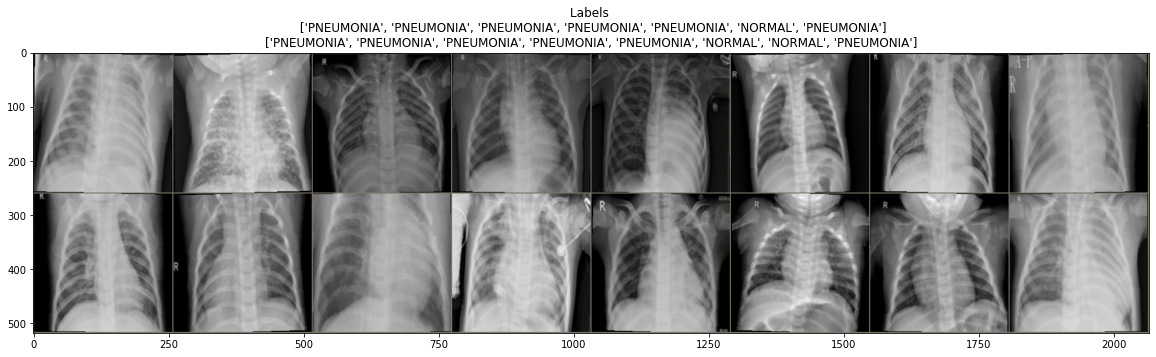

In [58]:
inputs,classes = next(iter(normDL1))
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

These look pretty good, they aren't "too" augmented (i.e. no big cropping, no reflections etc) so they still look like plausible x ray images, but the gaussian blur, brightness/exposure adjustments, and minor rotations should help bolster our training data. 

Note that because of the way we have our directories set up, we are going to create extra pnemo images as well, which we will need to separate when we re-load the saved images. 

Lets look at what a single element of our imagefolder looks like. 

In [ ]:
extra_normal1[0]

And lets double check that we know where the break between the classes are. 

In [32]:
extra_normal1[1340][-1]

0

In [33]:
extra_normal1[1341][-1]

1

Classes are stored as the last element with [:1341] being "normal and [1341:] being "pneumonia".

### Second set of transforms

In [59]:
normal_transforms2 = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(1.0, 1.5)),
       # transforms.ColorJitter(hue=0),
        transforms.RandomAffine(degrees = 5),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [60]:
extra2 = ImageFolder(new_dir,transform = normal_transforms2)

In [35]:
extra_normal2 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [61]:
normDL2 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

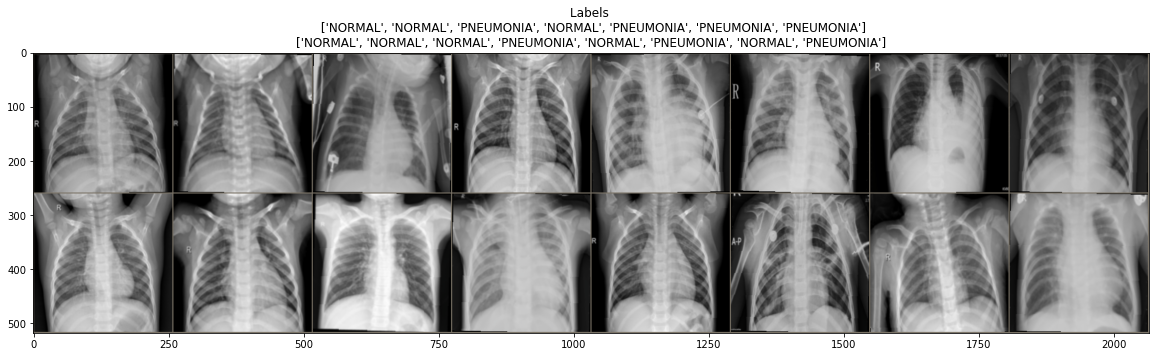

In [62]:
inputs,classes = next(iter(normDL2))
out = torchvision.utils.make_grid(inputs)

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [63]:
extra_normal1.classes

['NORMAL', 'PNEUMONIA']

save_image(img1, 'img1.png')

In [136]:
#normDL = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

In [113]:
#type(train_data)

torchvision.datasets.folder.ImageFolder

### Final set of transforms for all training data

In [64]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


In [46]:
#train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
#test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [47]:
#test_data = ImageFolder(test_dir, transform = data_transforms['test'])
#val_data = ImageFolder(val_dir, transform = data_transforms['val'])

In [88]:
train_data = ImageFolder(new_dir, transform = data_transforms['train'])
#val_data = ImageFolder(new_valdir,transform = data_transforms['val'])

In [91]:
val_data = ImageFolder(new_valdir,transform = data_transforms['val'])
test_data = ImageFolder(new_testdir, transform = data_transforms['test'])

In [89]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [90]:
class_names = train_data.classes

In [44]:
3875-1341-1341

1193

In [45]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [46]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

### Adding the extra "normal" images back in
Now we will subset ~ 2500 normal images from the augmented data and mix them back in to our training set. 

In [99]:
extra1[997]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.1179, -2.1179],
          [-1.6898, -1.6384, -1.6213,  ..., -2.0494, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -1.9638,  ..., -1.8782, -1.8782, -1.8782],
          [-2.1179, -2.1179, -1.9638,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -1.9638,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -1.9832, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -2.0357, -2.0357],
          [-1.5980, -1.5455, -1.5280,  ..., -1.9657, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -1.8782,  ..., -1.7906, -1.7906, -1.7906],
          [-2.0357, -2.0357, -1.8782,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -1.8782,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.7522, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [95]:
997+2770

3767

In [94]:
data = ImageFolder(new_dir, transform = data_transforms['train'])

In [100]:
ex1, p1 = train_test_split(extra1,test_size =  3875/(1341+3875), shuffle=False)

In [101]:
ex2, p2 = train_test_split(extra2, test_size = 4023/(1341+3875), shuffle = False)

In [102]:
train_data = ConcatDataset([data, ex1, ex2])

In [103]:
val_data = ImageFolder(new_valdir,transform = data_transforms['val'])
test_data = ImageFolder(new_testdir, transform = data_transforms['test'])

In [70]:
from torch.utils.data import random_split
import math

In [85]:
train_full = ConcatDataset([tr, extra1, extra2])
train_data, val_data = torch.utils.data.random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])


In [47]:
e1 = torch.utils.data.Subset(extra_normal1, list(range(1341)))

In [48]:
type(e1)

torch.utils.data.dataset.Subset

In [55]:
e2 = torch.utils.data.Subset(extra_normal2, list(range(1193)))

In [56]:
AUGdataset = ConcatDataset([train_data, e1, e2])

In [104]:
len(train_data)

5597

In [106]:
countlist = [train_data[i][-1] for i in range(len(train_data))]

In [109]:
traincount = dict(Counter(countlist))

In [58]:
AUGdataset[0][-1]

0

In [59]:
#takes a while so will keep commented out in future runs
AUGcounts = [AUGdataset[i][-1] for i in range(len(AUGdataset))]

In [62]:
AUGco = dict(Counter(AUGcounts))

In [63]:
AUGco

{0: 3875, 1: 3875}

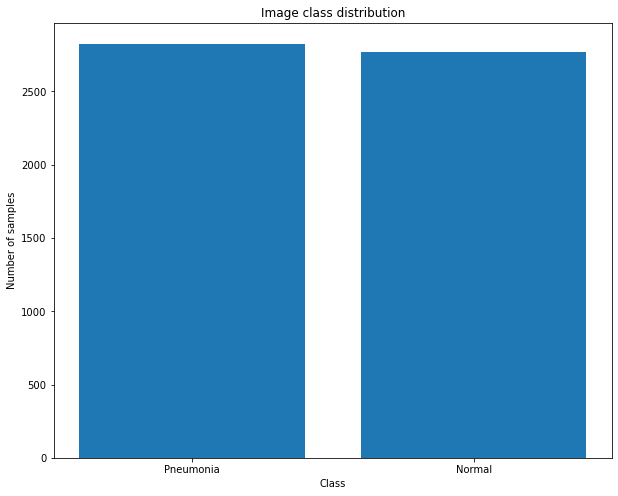

In [110]:
plt.figure(figsize = (10,8))
plt.bar(traincount.keys(),traincount.values())
plt.xlabel('Class')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'])
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

In [146]:
#valdo = [val_data[i][-1] for i in range(len(val_data))]

In [147]:
valco = dict(Counter(valdo))

In [148]:
valco

{0: 166, 1: 499}

In [149]:
testdo = [test_data[i][-1] for i in range(len(test_data))]
testco = dict(Counter(testdo))
testco

{0: 178, 1: 605}

In [ ]:
train_raw = ImageFolder(train_dir)
val_raw = ImageFolder

## Preprocessing & Modeling <a class="anchor" id="chapter2"></a>

We will employ transfer learning with a CNN trained on imagenet data. 

The way I am going to divide the data is to save the 624 "test" images for model evaluation/selection, and do an 80/20 split on the training data (now 7748 images), with the smaller split being our validation set to use during training. 

### Creating dataloaders for our datasets

In [71]:
total = len(AUGdataset)
print(total)

7750


In [72]:
train_size = int(0.8 * total)
val_size = total - train_size
train_data, val_data = torch.utils.data.random_split(AUGdataset, [train_size, val_size])

In [ ]:
torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [111]:
dataset_sizes = {'train': len(train_data), 'val':len(val_data),'test': len(test_data)}

In [112]:
dataset_sizes

{'train': 5597, 'val': 665, 'test': 783}

In [113]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 6,pin_memory=True)

In [114]:
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [115]:
#test_data = ImageFolder(test_dir, transform = data_transforms['test'])

In [116]:
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [117]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}

Lets take a look at what a single batch from our training data looks like

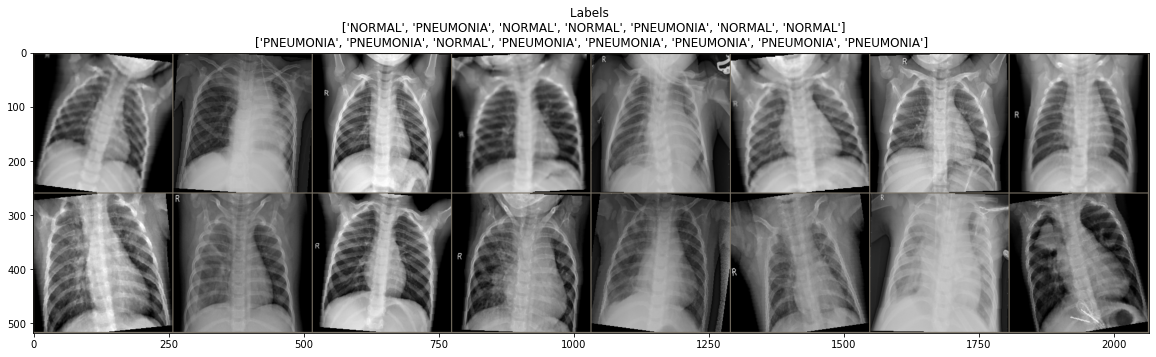

In [118]:
class_names = test_data.classes
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

# Model Training 

The following 2 functions are modified from the pytorch transfer learning tutorial documentation which can be found at the following link. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



In [119]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [120]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [121]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(dataset_sizes[phase])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Transfer Learning with Resnet18

In [122]:
#load in the pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [123]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title('Actual: {}             predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                #ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.xlabel(labels[j])
                imshow(inputs.cpu().data[j],figsize = (4,4))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Here is where we begin training

In [124]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1352 Acc: 0.9502
5597
val Loss: 0.0692 Acc: 0.9684
665

Epoch 1/9
----------
train Loss: 0.0679 Acc: 0.9757
5597
val Loss: 0.0362 Acc: 0.9865
665

Epoch 2/9
----------
train Loss: 0.0436 Acc: 0.9832
5597
val Loss: 0.0334 Acc: 0.9910
665

Epoch 3/9
----------
train Loss: 0.0336 Acc: 0.9875
5597
val Loss: 0.0343 Acc: 0.9865
665

Epoch 4/9
----------
train Loss: 0.0250 Acc: 0.9911
5597
val Loss: 0.0261 Acc: 0.9910
665

Epoch 5/9
----------
train Loss: 0.0170 Acc: 0.9930
5597
val Loss: 0.0566 Acc: 0.9805
665

Epoch 6/9
----------
train Loss: 0.0139 Acc: 0.9961
5597
val Loss: 0.0195 Acc: 0.9940
665

Epoch 7/9
----------
train Loss: 0.0113 Acc: 0.9959
5597
val Loss: 0.0221 Acc: 0.9910
665

Epoch 8/9
----------
train Loss: 0.0106 Acc: 0.9970
5597
val Loss: 0.0266 Acc: 0.9910
665

Epoch 9/9
----------
train Loss: 0.0063 Acc: 0.9987
5597
val Loss: 0.0247 Acc: 0.9910
665

Training complete in 4m 49s
Best val Acc: 0.993985


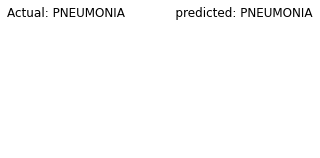

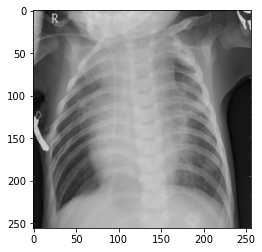

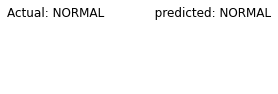

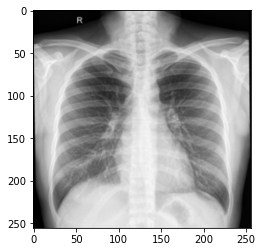

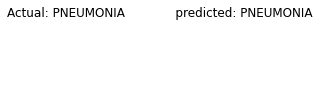

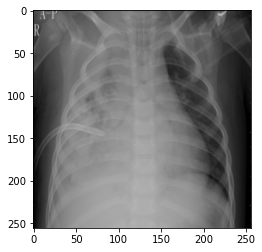

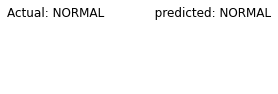

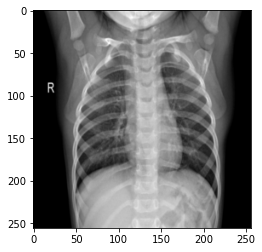

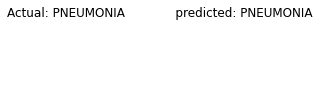

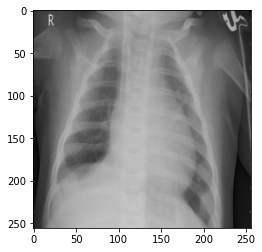

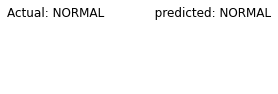

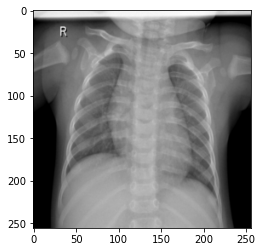

In [125]:
visualize_model(model_ft)

# Metrics

In [134]:
def ez_metrics(model, test_data = test_data):
    from sklearn.metrics import classification_report, f1_score
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

    test_load = DataLoader(test_data, batch_size = 1)
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for imgs, labels in test_load:
            x_batch, y_batch = imgs.to(device), labels.to(device)
            y_test_pred = model_ft(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    print(classification_report(y_true_list, y_pred_list))
    print("Accuracy Score:  ", accuracy_score(y_true_list, y_pred_list))
    print("F1 Score:  ", f1_score(y_true_list, y_pred_list))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_true_list, y_pred_list)
    disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
    disp.plot(ax=ax)  
    return y_pred_list, y_true_list

In [126]:
test_data = ImageFolder(new_testdir, transform = data_transforms['test'])

In [127]:
final_test = ImageFolder(test_dir,transform = data_transforms['test'])

In [129]:
test_load = DataLoader(test_data, batch_size = 1)

              precision    recall  f1-score   support

           0       1.00      0.52      0.69       234
           1       0.78      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.89      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624

Accuracy Score:   0.8205128205128205
F1 Score:   0.874439461883408


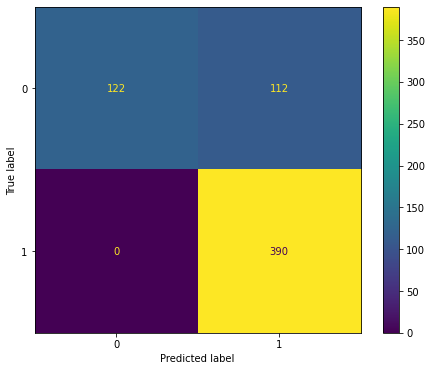

In [135]:
y_pred_list,y_true_list = ez_metrics(model_ft,final_test)

In [81]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

In [82]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [83]:
len(y_pred_list)

624

In [84]:
from sklearn.metrics import classification_report,accuracy_score


In [85]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78       234
           1       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.84       624
weighted avg       0.89      0.87      0.86       624



In [86]:
accuracy_score(y_true_list, y_pred_list)

0.8653846153846154

In [87]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

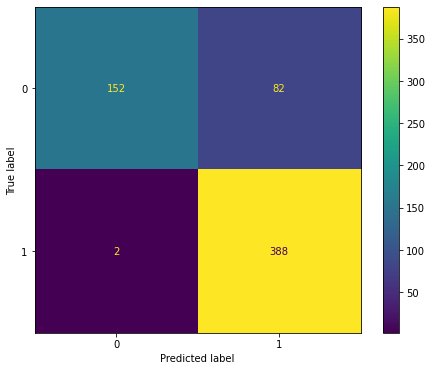

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [89]:
f1_score(y_true_list, y_pred_list)

0.9023255813953488

In [116]:
#torch.save(model_ft.state_dict(), '../models/model111_no_aug')

## Freezing the network except for the final layer. 

In [137]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [138]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=18)

Epoch 0/17
----------
train Loss: 0.2564 Acc: 0.8899
5597
val Loss: 0.1774 Acc: 0.9353
665

Epoch 1/17
----------
train Loss: 0.1714 Acc: 0.9343
5597
val Loss: 0.1535 Acc: 0.9414
665

Epoch 2/17
----------
train Loss: 0.1560 Acc: 0.9403
5597
val Loss: 0.1483 Acc: 0.9429
665

Epoch 3/17
----------
train Loss: 0.1542 Acc: 0.9419
5597
val Loss: 0.2354 Acc: 0.9098
665

Epoch 4/17
----------
train Loss: 0.1528 Acc: 0.9423
5597
val Loss: 0.2343 Acc: 0.9113
665

Epoch 5/17
----------
train Loss: 0.1429 Acc: 0.9446
5597
val Loss: 0.1581 Acc: 0.9444
665

Epoch 6/17
----------
train Loss: 0.1349 Acc: 0.9493
5597
val Loss: 0.2341 Acc: 0.9128
665

Epoch 7/17
----------
train Loss: 0.1172 Acc: 0.9548
5597
val Loss: 0.1418 Acc: 0.9459
665

Epoch 8/17
----------
train Loss: 0.1180 Acc: 0.9573
5597
val Loss: 0.1325 Acc: 0.9489
665

Epoch 9/17
----------
train Loss: 0.1291 Acc: 0.9521
5597
val Loss: 0.1651 Acc: 0.9414
665

Epoch 10/17
----------
train Loss: 0.1257 Acc: 0.9539
5597
val Loss: 0.1392 Acc:

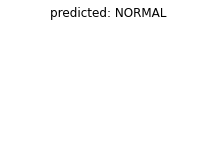

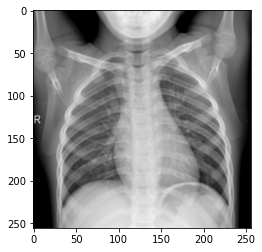

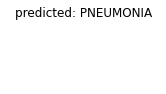

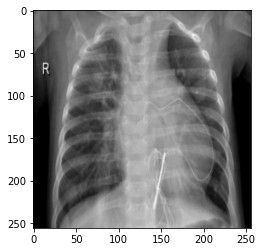

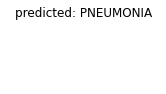

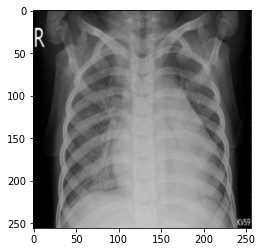

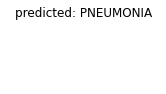

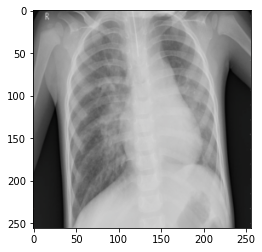

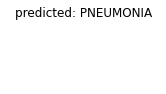

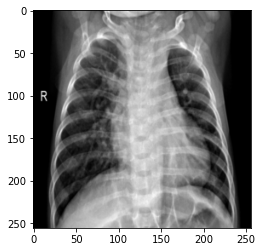

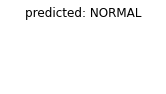

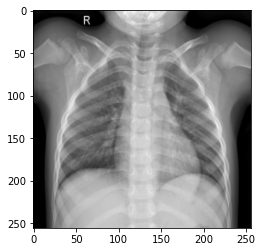

In [120]:
visualize_model(model_conv)


In [ ]:
from sklearn.metrics

In [139]:
final_data = ImageFolder(test_dir,transform = data_transforms['test'])

In [140]:
test_load = DataLoader(final_data,batch_size = 1,shuffle = True)

In [141]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_conv(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [142]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [143]:
len(y_pred_list)

624

In [145]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [146]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [147]:
accuracy_score(y_true_list, y_pred_list)

0.8766025641025641

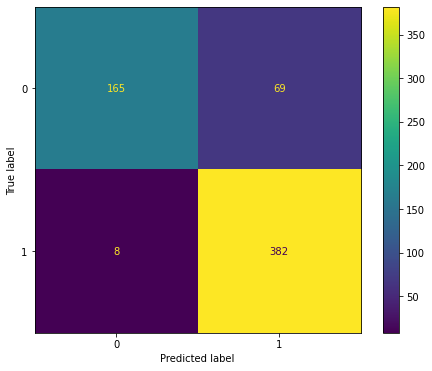

In [148]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [160]:
final_final = ImageFolder(val_dir,transform = data_transforms['test'])

In [161]:
test_load = DataLoader(final_final,batch_size = 1,shuffle = True)

In [149]:
f1_score(y_true_list, y_pred_list)

0.9084423305588585

NameError: name 'recall_score' is not defined

In [129]:
#torch.save(model_ft.state_dict(), '../models/model111_no_aug_frozen')

In [150]:
#odel = torch.load("train_5.pth")

def test(model, device, test_loader,verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            #test_loss += f.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            if verbose == True:
                print(pred, target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#test(model, 'cuda', testloader)

In [162]:
test(model_ft,device, test_load)

tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')

Test set: Accuracy: 14/16 (88%)



In [163]:
test(model_conv,device,test_load)

tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')

Test set: Accuracy: 15/16 (94%)



In [ ]:
torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [ ]:
#https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
def load_data(self):
    train_full = torchvision.datasets.ImageFolder(self.data_dir, transform=self.Transform)
    train_set, val_set = random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])

    self.train_classes = [label for _, label in train_set]
    if self.sample:
        # Need to get weight for every image in the dataset
        class_count = Counter(self.train_classes)
        class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
        # Can't iterate over class_count because dictionary is unordered

        sample_weights = [0] * len(train_set)
        for idx, (image, label) in enumerate(train_set):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(train_set), replacement=True)  
        train_loader = DataLoader(train_set, batch_size=self.batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

    val_loader = DataLoader(val_set, batch_size=self.batch_size)

    return train_loader, val_loader

In [ ]:
class EarlyStopping:
  def __init__(self, patience=1, delta=0, path='checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)

    https://pytorch.org/vision/stable/feature_extraction.html

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)